In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode
from PIL import Image
from datetime import datetime

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [2]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 1820, y = 525, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [356]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = np.floor(begin)
        iend = np.floor(end)
        linelen = end - begin

        dist = iend - ibegin + 1
        arr = np.linspace(0, dist, num=dist)
#       print(arr, dist, begin, ibegin, ibegin + dist)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist])
        arrout = np.linspace(begin - ibegin, linelen, tgtlen)

        return interpolate.splev(arrout, spl)
    

In [3]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

def RawToIRE(data):
    return (np.float32(data) / out_scale) + minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

In [260]:
FSC = 8
freq_mhz = (315.0 / 88.0) * FSC
freq_hz = freq_mhz * 1000000.0
linelen = FSC * 227.5

synctrig = IREToRaw(-20)
rot_lowtrig = IREToRaw(-50) # should only happen during rot

# This is designed to smooth out small rot etc and clarify the sync intervals

f_slpf_b = sps.firwin(49, 100000/freq_hz)
f_slpf_a = [1.0]
f_slpf_offset = 24

# This does the *real* work of detecting syncs...

f_syncid_b, f_syncid_a = sps.butter(3, 0.002)
f_syncid_offset = 320


In [378]:
infd = open('ve-zone.ld', 'rb')

bufsize = 1820 * 525 * 30
inbuf = infd.read(bufsize * 2)
data = np.fromstring(inbuf, 'uint16', len(inbuf)//2)

# Before official rot correction, we need to remove low spikes to avoid confusing the sync filter
data_despike = data.copy()
data_despike[np.where(data < rot_lowtrig)] = IREToRaw(0)
data_despike[np.where(data > IREToRaw(120))] = IREToRaw(120)

lpfdata = sps.lfilter(f_slpf_b, f_slpf_a, data_despike)[f_slpf_offset:]
sdata = lpfdata < synctrig

sfdata = sps.lfilter(f_syncid_b, f_syncid_a, sdata)[f_syncid_offset:]
# Clip sfdata so there are no false low peaks
sfdata[np.where(sfdata < .05)] = .05



In [379]:

def inrange(x, mi, ma):
    return (x >= mi) and (x <= ma)

def inrange_fsc(x, mi, ma):
    xf = x / FSC
    return (xf >= mi) and (xf <= ma)


In [380]:
# This is a (seemingly) reliable indicator of a VSYNC transition - or possibly *severe* rot.
invsync = sfdata > 0.6
# Catch the edges, and add one to the results to easily determine rising/falling edges
vsync_boundary = (np.where(np.diff(invsync))[0]) + 1

fields = []

for v in range(0, len(vsync_boundary)):
    if invsync[vsync_boundary[v]]: # Rising edge found
        
        # Determine % of sync before sync start
        
        vb = vsync_boundary[v]
        # Rewind to the previous trough for more accurate measurement
        presync = vb - int(140 * FSC) + np.argmin(sfdata[vb - int(80 * FSC): vb])
        presync_sum = np.sum(sfdata[presync - int(227.5 * FSC * 4.25): presync])
#        print(v, vsync_boundary[v], presync_sum, end = ' ')

        # Find the end of VSYNC - with debounce protection (using regular end of VSYNC - ~66x FSC)
        for v2 in range(v + 1, len(vsync_boundary)):
            ve = vsync_boundary[v2]
            gap = vsync_boundary[v2] - vsync_boundary[v]

            if invsync[ve] == False and inrange_fsc(gap, 650, 670):
                postsync = ve + np.argmin(sfdata[ve:ve + int(80 * FSC)])
                postsync_sum = np.sum(sfdata[postsync: postsync + int(227.5 * FSC * 4.25)])

#                print(postsync_sum, presync_sum + postsync_sum)
                
                fields.append((postsync, presync_sum > postsync_sum))

print(fields)

[(256463, False), (734460, True), (1212052, False), (1690049, True), (2167646, False), (2645648, True), (3123246, False), (3601242, True), (4078838, False), (4556835, True), (5034432, False), (5512433, True), (5990026, False), (6468020, True), (6945619, False), (7423623, True), (7901224, False), (8379217, True), (8856812, False), (9334810, True), (9812404, False), (10290397, True), (10767996, False), (11245997, True), (11723596, False), (12201590, True), (12679186, False), (13157179, True), (13634777, False), (14112780, True), (14590383, False)]


1819.34939759
1820.97991968
(458640,)
uint8 (504, 910) (504, 910)


/home/cpage/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


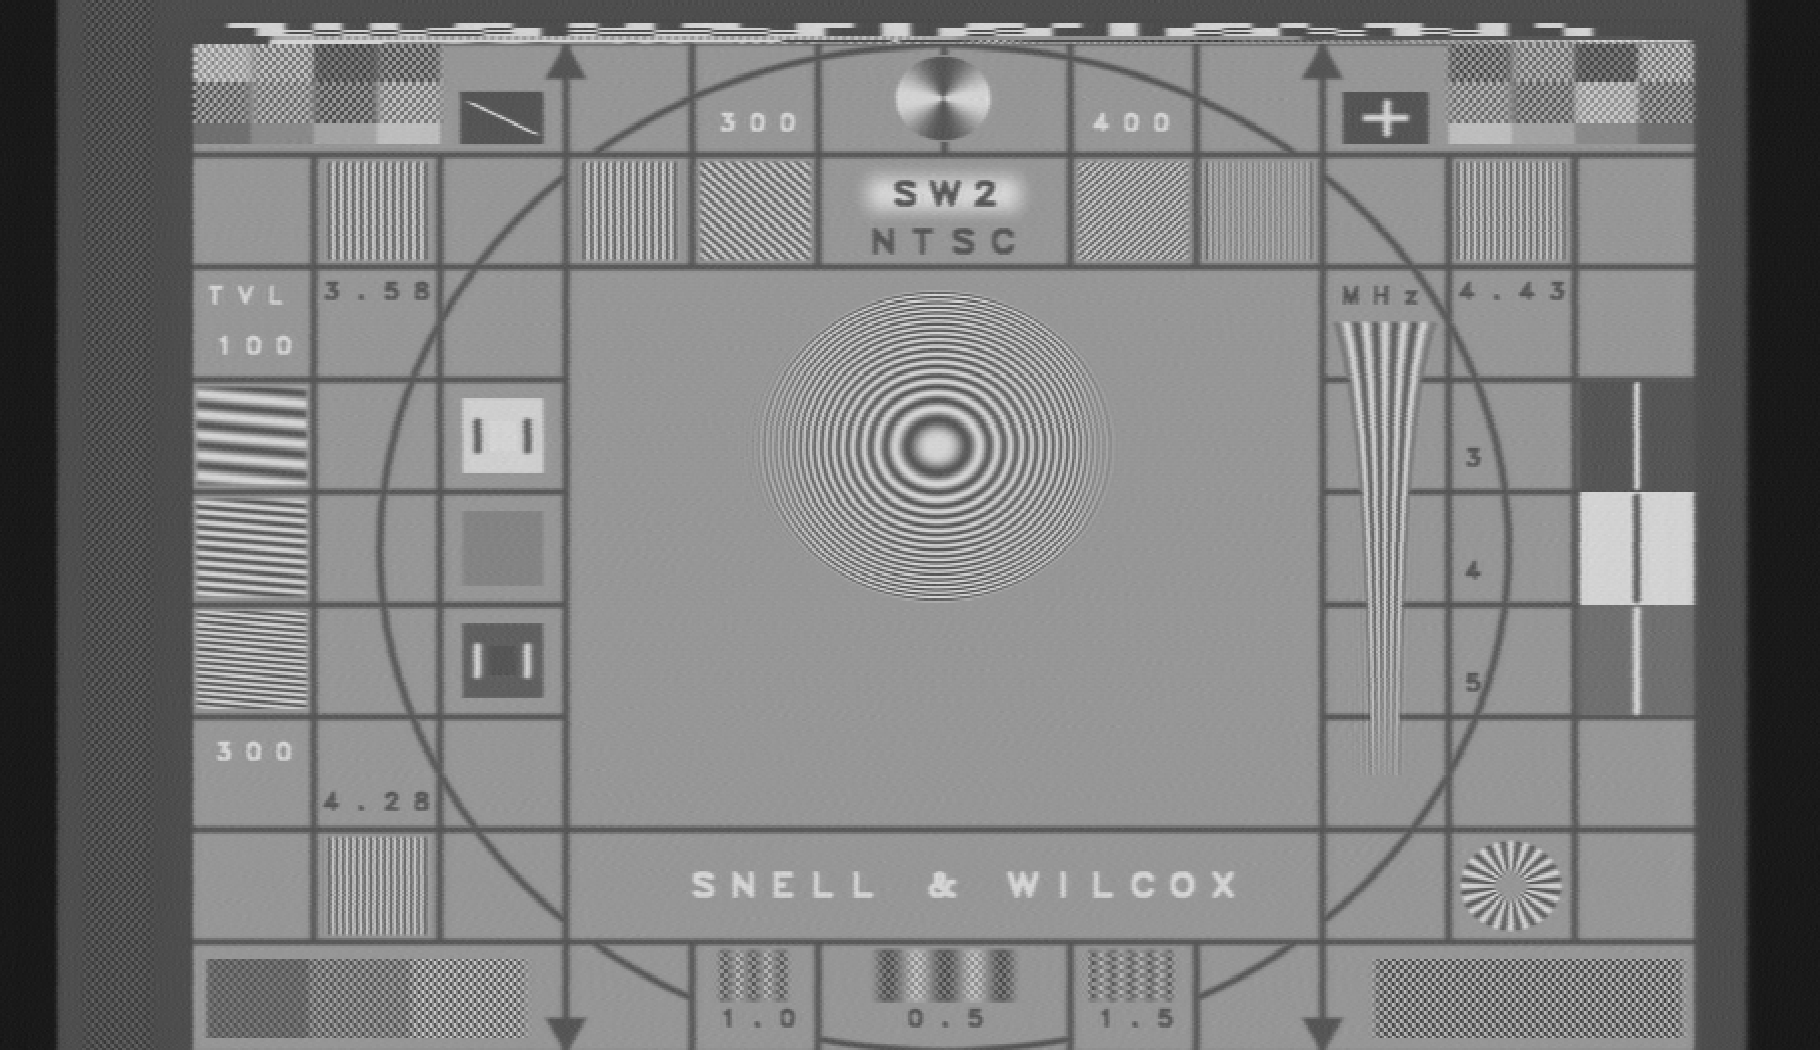

In [384]:
#for f in range(len(fields) - 1):

framebuf = np.zeros(910 * 504, dtype=np.uint16)

lineloc = np.zeros((504, 2), dtype=np.float32)

# First stage frameup - does a decent job even on rotted disks, but does not use phase/line start correction

fnum = -1
sf = 6
for f in range(sf, sf + 4):
    fs = fields[f][0]
    
    if fnum == -1 and fields[f][1] == False:
        continue
        
    fnum += 1

    # 'start' our field data about 170 samples before the first proper sync
    if fields[f][1] == True:
        begin = fs + int(757 * FSC)
    else:
        begin = fs + int(871 * FSC)

    subset = sfdata[begin:begin + int(FSC * 227.5 * 255)]
    peaksr = np.logical_and((subset[1:-1] > subset[2:]), (subset[1:-1] > subset[:-2]))
    peaks = np.where(peaksr)[0]

    print((peaks[250]-peaks[1])/249)

    for line in range(0, 252):
        sline = scale(data, begin + peaks[line], begin + peaks[line + 1], 910)
        l = (line * 2) + (0 if fields[f][1] else 1)
        
        lineloc[l] = [begin + peaks[line], begin + peaks[line + 1]]
        framebuf[l * 910:((l + 1) * 910)] = sline[0:910]
        
    if fnum == 1:
        break

drawdata(framebuf, x = 910, hscale = 2, vscale = 2)


1819.1944444444443